In [1]:
# The homework files for group 30 (Marvin Wurch)//homework 3


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
import time

In [2]:
class GridWorld:
    def __init__(self, rows, cols, start, goal, walls={}, traps={}, max_steps=10000):
        self.rows = rows  # Number of rows in the grid
        self.cols = cols  # Number of columns in the grid
        self.start = start  # Starting position of the agent
        self.goal = goal  # Goal position that the agent should reach
        self.walls = walls  # Set of wall positions, which are non-passable
        self.traps = traps  # Set of trap positions, which give a negative reward when passed
        self.state = start  # Current position of the agent
        self.actions = ["LEFT", "UP", "RIGHT", "DOWN"]  # List of possible actions
        self.max_steps = max_steps  # Maximum number of steps per episode
        self.current_steps = 0  # Current number of steps in the episode

    def reset(self):
        """Reset the environment to its initial state and set current_steps to 0."""
        self.state = self.start
        self.current_steps = 0
        return self.state

    def is_terminal(self, state):
        """Check if the given state is terminal (i.e., the goal state)."""
        return state == self.goal

    def step(self, action):
        """
        Take a step in the environment based on the given action.

        This method updates the agent's position and returns the next state, reward, and
        whether the state is terminal. The reward structure is as follows:
        - A small penalty for each step (-0.2)
        - An additional penalty for stepping on a trap (-10)
        - A bonus for reaching the goal (10)
        """
        assert action in self.actions, "Invalid action"

        x, y = self.state

        if action == "LEFT":
            y = max(y - 1, 0)
        elif action == "UP":
            x = max(x - 1, 0)
        elif action == "RIGHT":
            y = min(y + 1, self.cols - 1)
        elif action == "DOWN":
            x = min(x + 1, self.rows - 1)

        next_state = (x, y)
        reward = -0.2  # Add a small penalty for each step
        done = False

        if next_state in self.walls:
            next_state = self.state
        elif next_state in self.traps:
            reward += -10
        elif self.is_terminal(next_state):
            reward += 10
            done = True

        self.state = next_state
        self.current_steps += 1

        # Check if the maximum number of steps is reached
        if self.current_steps >= self.max_steps:
            done = True

        return next_state, reward, done  # Return the next state, the immediate reward and if episode is done
    
    def render(self):
        """
        Render the current state of the grid world.

        This method displays the playing field using simple characters to represent
        different elements of the grid:
        - 'S': start
        - 'G': goal
        - 'W': wall
        - 'T': trap
        - 'A': agent
        - ' ': empty space
        """
        for r in range(self.rows):
            for c in range(self.cols):
                cell = (r, c)
                if cell == self.start:
                    print("  S  ", end="")
                elif cell == self.goal:
                    print("  G  ", end="")
                elif cell in self.walls:
                    print("  W  ", end="")
                elif cell in self.traps:
                    print("  T  ", end="")
                else:
                    print("  .  ", end="")
            print()

In [3]:
def get_arrow(action):
        # helper function for better visualization
        if action == "LEFT":
            return "←"
        elif action == "UP":
            return "↑"
        elif action == "RIGHT":
            return "→"
        elif action == "DOWN":
            return "↓"
def display_policy(policy, gridworld):
        # for a nice visualization of the policy
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(-.5, gridworld.cols, 1))
        ax.set_yticks(np.arange(-.5, gridworld.rows, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, gridworld.cols - 0.5)
        ax.set_ylim(-0.5, gridworld.rows - 0.5)
        ax.grid(True, color="k", linestyle="-", linewidth=1)

        for r in range(gridworld.rows):
            for c in range(gridworld.cols):
                if (r,c) in policy:   
                    cell = (r, c)
                    if cell == gridworld.start:
                        ax.text(c, r, "S", fontsize=20, ha="center", va="center")
                        arrow = get_arrow(policy[r, c])
                        ax.text(c, r, arrow, fontsize=20, ha="center", va="top")
                    elif cell == gridworld.goal:
                        ax.text(c, r, "G", fontsize=20, ha="center", va="center")
                    elif cell in gridworld.walls:
                        ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor="k"))
                    elif cell in gridworld.traps:
                        ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor="red"))
                        arrow = get_arrow(policy[r, c])
                        ax.text(c, r, arrow, fontsize=20, ha="center", va="center")
                    else:
                        arrow = get_arrow(policy[r, c])
                        ax.text(c, r, arrow, fontsize=20, ha="center", va="center")
                else:
                    cell = (r, c)
                    if cell == gridworld.start:
                        ax.text(c, r, "S", fontsize=20, ha="center", va="center")
                        ax.text(c, r, 'NV', fontsize=20, ha="center", va="top")
                    elif cell == gridworld.goal:
                        ax.text(c, r, "G", fontsize=20, ha="center", va="center")
                    elif cell in gridworld.walls:
                        ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor="k"))
                    elif cell in gridworld.traps:
                        ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor="red"))
                        ax.text(c, r, 'NV', fontsize=20, ha="center", va="top")
                    else:
                        ax.text(c, r, 'NV', fontsize=20, ha="center", va="top")
                        
        plt.gca().invert_yaxis()
        plt.show()

In [4]:
# Epsilon-greedy policy function
def epsilon_greedy_policy(Q, state, actions, epsilon):
    # With probability epsilon, take a random action
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    # Otherwise, take the action with the highest Q-value
    else:
        action_values = [Q[(state, action)] for action in actions]
        return actions[np.argmax(action_values)]

In [5]:
def tabular_mc_estimate_policy_iteration(env, num_episodes, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay_rate=0.99, gamma=1, print_interval=10000):
    # Initialize Q-values and returns for all state-action pairs
    Q = {}
    returns = {}
    for row in range(env.rows):
        for col in range(env.cols):
            state = (row, col)
            for action_index, action in enumerate(env.actions):
                Q[(state, action)] = 0
                returns[(state, action)] = []

    # Initialize the policy
    policy = {}
    # Initialize epsilon to the start value
    epsilon = epsilon_start

    # List for recording wall-clock time, average Return-per-Episode
    wallclock_times = []
    returns_per_ep = []
    start_time = time.time()

    # Loop for a specified number of episodes
    for episode in range(num_episodes):
        # step count episode
        steps = 0
        # record wall-clock time
        wallclock_times.append(time.time() - start_time)
        # Initialize an empty list to store the episode data (state, action, reward)
        episode_data = []
        # Reset the environment and get the initial state
        state = env.reset()
        done = False

        # Total reward for the episode
        total_reward = 0

        # Loop until the episode is done
        while not done:
            # Choose an action using the epsilon-greedy policy
            action = epsilon_greedy_policy(Q, state, env.actions, epsilon)
            # Take a step in the environment using the chosen action
            next_state, reward, done = env.step(action)
            steps += 1
            # Store the state, action, and reward in the episode data list
            episode_data.append((state, action, reward))
            # Update the current state
            state = next_state
            # Add the reward to the total reward
            total_reward += reward

        # Initialize the cumulative reward (return) as 0
        G = 0
        # Initialize an empty set to store visited state-action pairs
        visited_state_actions = set()

        

        # Iterate through the episode data in reverse order
        for t in reversed(range(len(episode_data))):
            # Get the state, action, and reward at time step t
            state, action, reward = episode_data[t]
            # Update the cumulative reward (return)
            G = gamma * G + reward

            

            # If the state-action pair has not been visited in this episode and the state is not terminal
            if (state, action) not in visited_state_actions and not env.is_terminal(state):
                # Add the state-action pair to the visited set
                visited_state_actions.add((state, action))
                # Add the cumulative reward (return) to the returns list for this state-action pair
                returns[(state, action)].append(G)
                # Update the Q-value as the average of the returns
                Q[(state, action)] = np.mean(returns[(state, action)])

                # Update the policy for this state
                action_values = [Q[(state, a)] for a in env.actions]
                policy[state] = env.actions[np.argmax(action_values)]
        # Decay epsilon after each episode
        epsilon = max(epsilon_end, epsilon * epsilon_decay_rate)

        # Print the policy every print_interval episodes
        if (episode + 1) % print_interval == 0:
            print(f'MC Episode: {episode + 1}')
            display_policy(policy, env)

        # save reward
        returns_per_ep.append((steps, total_reward, total_reward/steps, np.mean(total_reward)))

    return policy, Q, wallclock_times, returns_per_ep, epsilon, returns

In [6]:
# 1 step SARSA control
def one_step_sarsa(env, num_episodes, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay_rate=0.99, alpha = 0.5, gamma=1, print_interval=10000):
    # Initialize Q-values for all state-action pairs
    Q = {}
    for row in range(env.rows):
        for col in range(env.cols):
            state = (row, col)
            for action in env.actions:
                Q[(state, action)] = 0

    # Initialize the policy
    policy = {}
    # Initialize epsilon to the start value
    epsilon = epsilon_start

    # List for recording wall-clock time, average Return-per-Episode
    wallclock_times = []
    returns_per_ep = []
    start_time = time.time()


    # Loop for a specified number of episodes
    for episode in range(num_episodes):
        steps = 0
        # record wall-clock time
        wallclock_times.append(time.time() - start_time)
        # Reset the environment and get the initial state
        state = env.reset()
        done = False
        # Choose an action using the epsilon-greedy policy
        action = epsilon_greedy_policy(Q, state, env.actions, epsilon)

        total_reward = 0
        # Loop until the episode is done
        while not done:            
            # Take a step in the environment using the chosen action
            next_state, reward, done = env.step(action)
            steps += 1
            # choose a' from next_state unsing policy derived form Q
            next_action = epsilon_greedy_policy(Q, next_state, env.actions, epsilon)
            # update Q(s, a)
            Q[(state, action)] += alpha * (reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])
            
            total_reward += reward
            # Update the current state and action
            state, action = next_state, next_action

            # update policy for this state
            action_values = [Q[(state, a)] for a in env.actions]
            policy[state] = env.actions[np.argmax(action_values)]
        
        # Decay epsilon after each episode
        epsilon = max(epsilon_end, epsilon * epsilon_decay_rate)



        # Print the policy every print_interval episodes
        if (episode + 1) % print_interval == 0:
            print(f'SARSA Episode: {episode + 1}')
            display_policy(policy, env)
        
        # Calculate average reward
        returns_per_ep.append((steps, total_reward, total_reward/steps, np.mean(total_reward)))

        
    return policy, Q ,wallclock_times, returns_per_ep, epsilon

In [7]:
# Example Girdworlds
empty_gridworld = GridWorld(rows=4, cols=4, start=(0, 0), goal=(3, 3))
simple_gridworld = GridWorld(rows=4, cols=4, start=(3, 0), goal=(3, 3),
                              walls={(1, 1), (2, 1)},
                              traps={(3, 1)})

complex_gridworld = GridWorld(rows=5, cols=5, start=(0, 0), goal=(4, 4),
                               walls={(1, 1), (1, 2), (2, 1), (3, 3), (3, 4)},
                               traps={(3, 0), (3, 1), (1, 3)})

complex_gridworld2 = GridWorld(rows=6, cols=6, start=(0, 0), goal=(5, 5),
                               walls={(1, 1), (1, 2), (1, 4), (2, 4), (3, 1), (3, 3), (4, 1), (4, 3), (4, 4), (5, 1)},
                               traps={(2, 2), (2, 3), (4, 2)})



narrow_path_gridworld = GridWorld(rows=6, cols=6, start=(0, 0), goal=(5, 5),
                                   walls={(1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
                                          (3, 1), (3, 2), (3, 3), (3, 4), (3, 5)},
                                   traps={(4, 0), (4, 5)})

gridworld1 = GridWorld(rows=5, cols=4, start=(2, 0), goal=(2, 2),
                               walls={(1, 1), (2, 1), (3, 1)},
                               traps={(1, 2), (1, 3), (3, 2)})


#empty_gridworld.render()
# print()
#simple_gridworld.render()
# print()
complex_gridworld.render()
# print()
#complex_gridworld2.render()
# print()
# narrow_path_gridworld.render()
# Print()
#gridworld1.render()

  S    .    .    .    .  
  .    W    W    T    .  
  .    W    .    .    .  
  T    T    .    W    W  
  .    .    .    .    G  


MC Episode: 1000


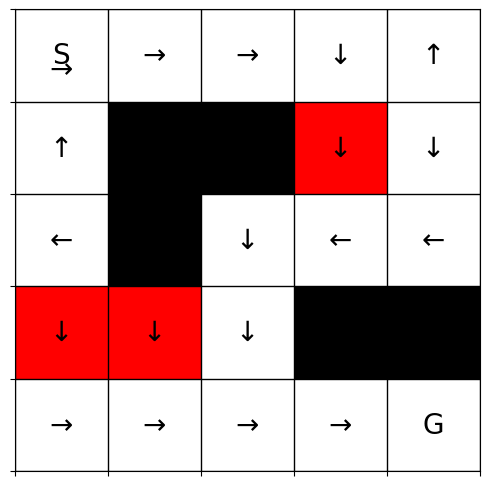

SARSA Episode: 1000


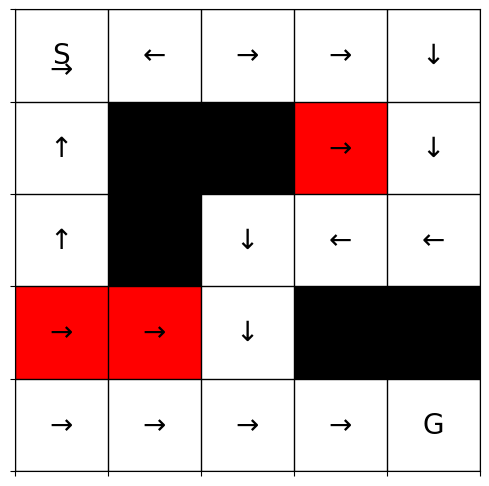

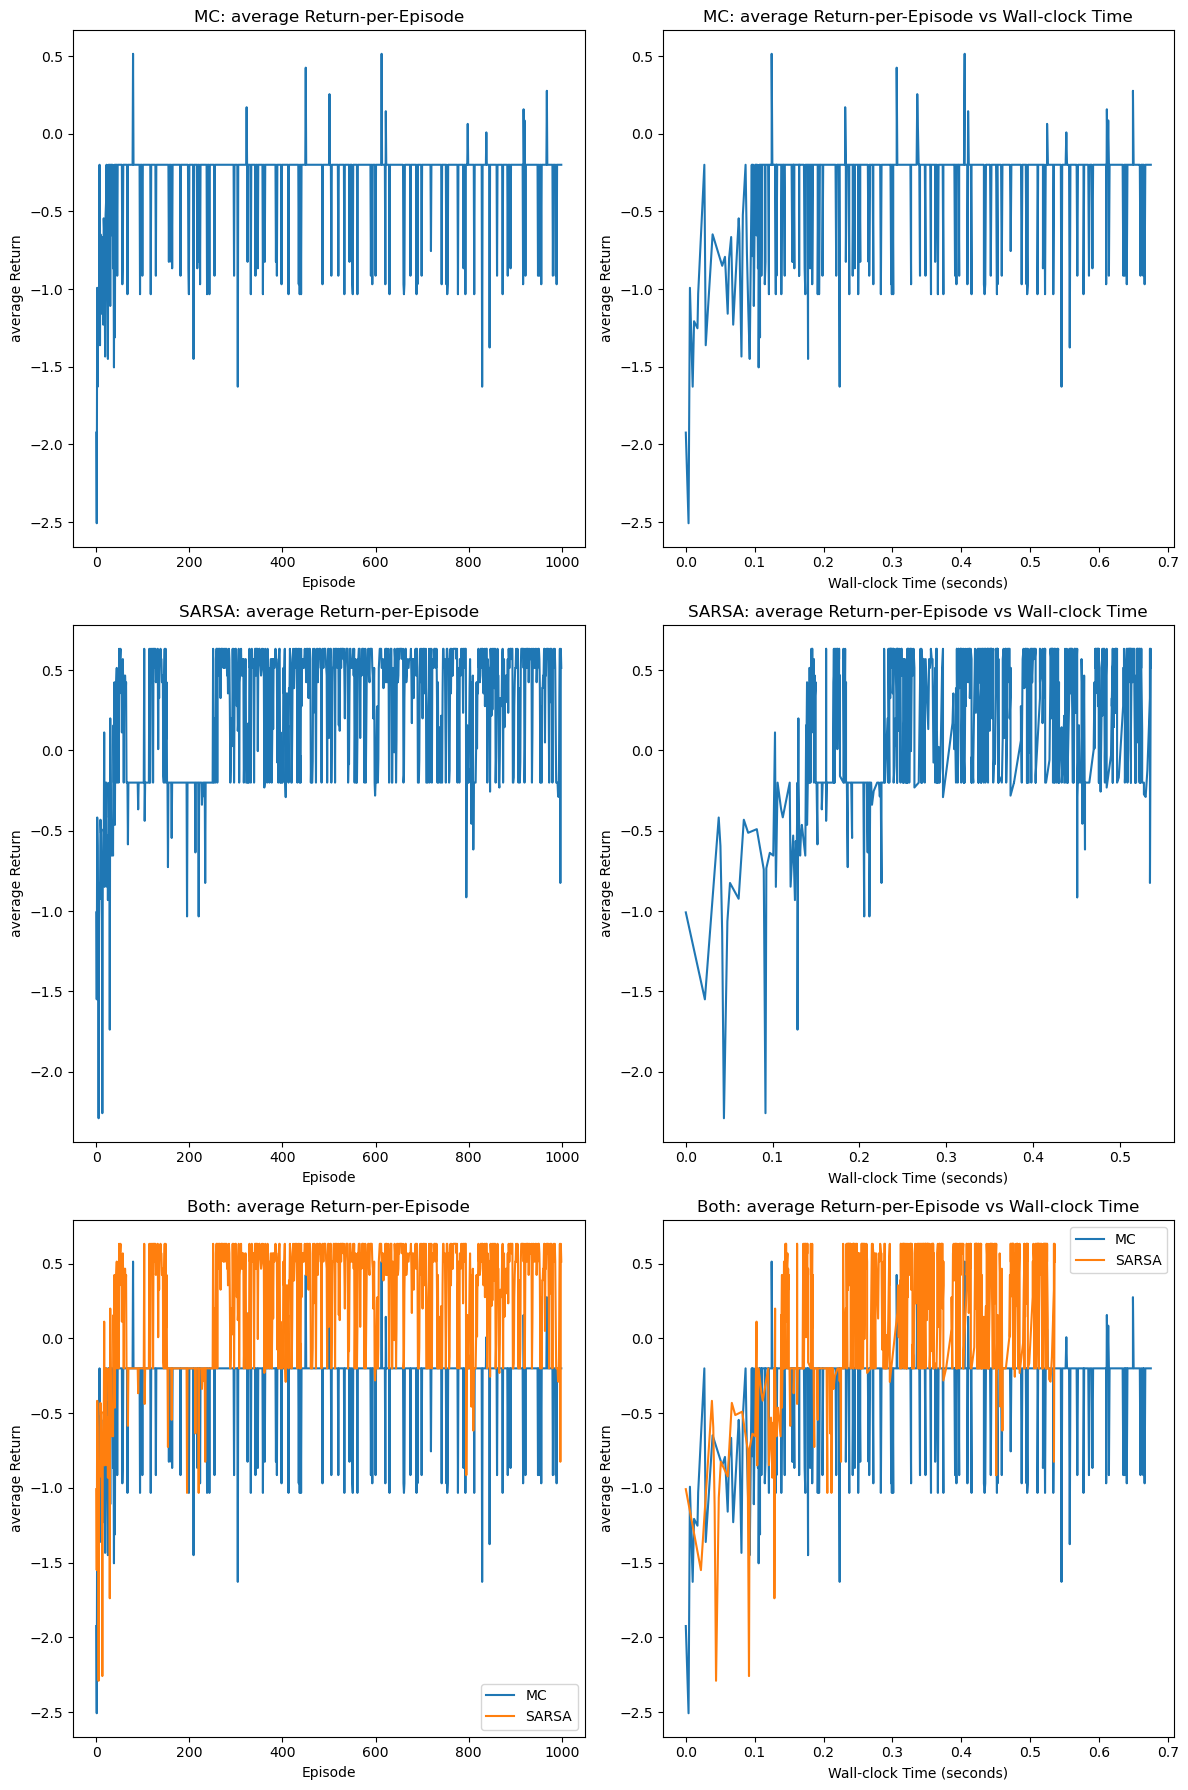

In [30]:
policy_mc, Q_mc ,wallclock_times_mc, returns_mc, _,_ = tabular_mc_estimate_policy_iteration(
    complex_gridworld, num_episodes=1000, epsilon_start=1, epsilon_end=0.1, epsilon_decay_rate=0.975, gamma=1, print_interval=1000)
policy_sarsa, Q_sarsa ,wallclock_times_sarsa, returns_sarsa, _ = one_step_sarsa(
    complex_gridworld, num_episodes=1000, epsilon_start=1, epsilon_end=0.1, epsilon_decay_rate=0.975, alpha = 0.5, gamma=1, print_interval=1000)
# policy_mc, Q_mc ,wallclock_times_mc, returns_mc, _,_ = tabular_mc_estimate_policy_iteration(
#     simple_gridworld, num_episodes=1000, epsilon_start=1, epsilon_end=0.1, epsilon_decay_rate=0.975, gamma=1, print_interval=1000)
# policy_sarsa, Q_sarsa ,wallclock_times_sarsa, returns_sarsa, _ = one_step_sarsa(
#     simple_gridworld, num_episodes=1000, epsilon_start=1, epsilon_end=0.1, epsilon_decay_rate=0.975, alpha = 0.5, gamma=1, print_interval=1000)
 

# # Get the average returns per episode using list comprehension
average_returns_mc = [x[2] for x in returns_mc]
average_returns_sarsa = [x[2] for x in returns_sarsa]
# # this would be np.mean
# average_returns_mc = [x[3] for x in returns_mc]
# average_returns_sarsa = [x[3] for x in returns_sarsa]



# Plot the results
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

# Plot for MC 
ax[0, 0].plot(average_returns_mc, label='MC')
#ax[0, 0].invert_yaxis()
ax[0, 0].set_title('MC: average Return-per-Episode')
ax[0, 0].set_xlabel('Episode')
ax[0, 0].set_ylabel('average Return')

ax[0, 1].plot(wallclock_times_mc, average_returns_mc, label='MC')
#ax[0, 1].invert_yaxis()
ax[0, 1].set_title('MC: average Return-per-Episode vs Wall-clock Time')
ax[0, 1].set_xlabel('Wall-clock Time (seconds)')
ax[0, 1].set_ylabel('average Return')

# Plot for SARSA
ax[1, 0].plot(average_returns_sarsa, label='SARSA')
#ax[1, 0].invert_yaxis()
ax[1, 0].set_title('SARSA: average Return-per-Episode')
ax[1, 0].set_xlabel('Episode')
ax[1, 0].set_ylabel('average Return')

ax[1, 1].plot(wallclock_times_sarsa, average_returns_sarsa, label='SARSA')
#ax[1, 1].invert_yaxis()
ax[1, 1].set_title('SARSA: average Return-per-Episode vs Wall-clock Time')
ax[1, 1].set_xlabel('Wall-clock Time (seconds)')
ax[1, 1].set_ylabel('average Return')

# Plot for both MC and SARSA
ax[2, 0].plot(average_returns_mc, label='MC')
ax[2, 0].plot(average_returns_sarsa, label='SARSA')
#ax[2, 0].invert_yaxis()
ax[2, 0].set_title('Both: average Return-per-Episode')
ax[2, 0].set_xlabel('Episode')
ax[2, 0].set_ylabel('average Return')
ax[2, 0].legend()

ax[2, 1].plot(wallclock_times_mc, average_returns_mc, label='MC')
ax[2, 1].plot(wallclock_times_sarsa, average_returns_sarsa, label='SARSA')
#ax[2, 1].invert_yaxis()
ax[2, 1].set_title('Both: average Return-per-Episode vs Wall-clock Time')
ax[2, 1].set_xlabel('Wall-clock Time (seconds)')
ax[2, 1].set_ylabel('average Return')
ax[2, 1].legend()

plt.tight_layout()
plt.show()


In [31]:
# Task 3
# 1 step SARSA control starting 
def one_step_sarsa_one_state(choosen_state, choosen_action, Q, env, num_episodes, epsilon_start, epsilon_end=0.1, epsilon_decay_rate=0.99, alpha = 0.5, gamma=1, print_interval=10000):
    
    specific_Q = []
    # Initialize epsilon to the start value
    epsilon = epsilon_start
    # Loop for a specified number of episodes
    for episode in range(num_episodes):
        # Reset the environment and get the initial state
        state = env.reset()
        done = False
        # Choose an action using the epsilon-greedy policy
        action = epsilon_greedy_policy(Q, state, env.actions, epsilon)

        # Loop until the episode is done
        while not done:            
            # Take a step in the environment using the chosen action
            next_state, reward, done = env.step(action)
            # choose a' from next_state unsing policy derived form Q
            next_action = epsilon_greedy_policy(Q, next_state, env.actions, epsilon)
            if (Q[((state, action))] == Q[(choosen_state, choosen_action)]):
                # update Q(s, a)
                Q[(state, action)] += alpha * (reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])
            
            # Update the current state and action
            state, action = next_state, next_action
        
        # Decay epsilon after each episode
        epsilon = max(epsilon_end, epsilon * epsilon_decay_rate)

        # save specific Q value every
        specific_Q.append(Q[(choosen_state, choosen_action)])


        
    return specific_Q

def tabular_mc_estimate_policy_iteration_one_state(choosen_state, choosen_action, Q, returns, env, num_episodes, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay_rate=0.99, gamma=1, print_interval=10000):
    # Initialize epsilon to the start value
    epsilon = epsilon_start
    # Store Q values for chosen state-action pair
    specific_Q = [] 

    # Loop for a specified number of episodes
    for episode in range(num_episodes):
        # Initialize an empty list to store the episode data (state, action, reward)
        episode_data = []
        # Reset the environment and get the initial state
        state = env.reset()
        done = False

        # Loop until the episode is done
        while not done:
            # Choose an action using the epsilon-greedy policy
            action = epsilon_greedy_policy(Q, state, env.actions, epsilon)
            # Take a step in the environment using the chosen action
            next_state, reward, done = env.step(action)
            # Store the state, action, and reward in the episode data list
            episode_data.append((state, action, reward))
            # Update the current state
            state = next_state

        # Initialize the cumulative reward (return) as 0
        G = 0
        # Initialize an empty set to store visited state-action pairs
        visited_state_actions = set()

        # Iterate through the episode data in reverse order
        for t in reversed(range(len(episode_data))):
            # Get the state, action, and reward at time step t
            state, action, reward = episode_data[t]
            # Update the cumulative reward (return)
            G = gamma * G + reward
            # If the state-action pair has not been visited in this episode and the state is not terminal
            if (state, action) not in visited_state_actions and not env.is_terminal(state):
                # Add the state-action pair to the visited set
                visited_state_actions.add((state, action))
                # Add the cumulative reward (return) to the returns list for this state-action pair
                returns[(state, action)].append(G)

                if (Q[((state, action))] == Q[(choosen_state, choosen_action)]):
                    # Update the Q-value as the average of the returns
                    Q[(state, action)] = np.mean(returns[(state, action)])
        # Decay epsilon after each episode
        epsilon = max(epsilon_end, epsilon * epsilon_decay_rate)
        # save specific Q value every
        specific_Q.append(Q[(choosen_state, choosen_action)])

    return specific_Q


In [32]:
# wrapper for iteratinon
def task_prob_worng_mc(env, action, end_epsilon_mc, Q_mc, returns_mc):
    specific_Q_mc = tabular_mc_estimate_policy_iteration_one_state(
        choosen_state=env.start, choosen_action=action, Q=Q_mc, returns=returns_mc, env=env, num_episodes=1000, epsilon_start=end_epsilon_mc, epsilon_end=0.1, epsilon_decay_rate=0.975, gamma=1, print_interval=10000)
    return specific_Q_mc
def task_prob_worng_sarsa(env, action, end_epsilon_sarsa, Q_sarsa):
    specific_Q_sarsa = one_step_sarsa_one_state(
        choosen_state=env.start, choosen_action=action,Q=Q_sarsa, env=env, num_episodes=1000, epsilon_start=end_epsilon_sarsa, epsilon_end=0.1, epsilon_decay_rate=0.975, alpha = 0.5, gamma=1, print_interval=10000)
    return specific_Q_sarsa


MC Episode: 100


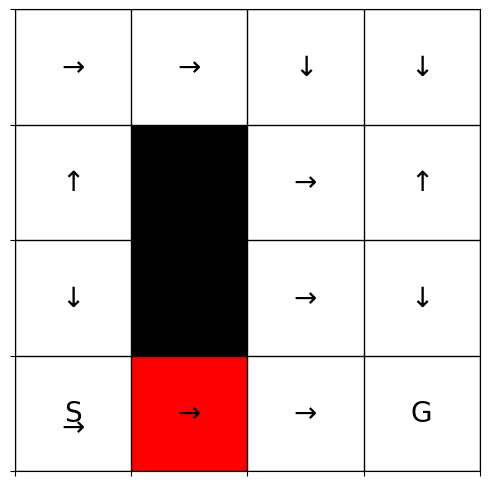

SARSA Episode: 100


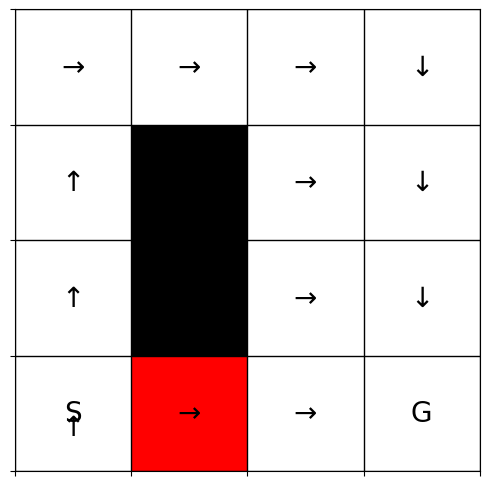

0  iterations taken
10  iterations taken
20  iterations taken
30  iterations taken
40  iterations taken
50  iterations taken
60  iterations taken
70  iterations taken
80  iterations taken
90  iterations taken


In [33]:
# select env
env = simple_gridworld
# starting at a half trained state as i understood it
# train first for 150 episodes - roughly the half way point of average return
_, Q_mc, _, _, end_epsilon_mc, returns_mc = tabular_mc_estimate_policy_iteration(
    env, num_episodes=100, epsilon_start=1, epsilon_end=0.1, epsilon_decay_rate=0.975, gamma=1, print_interval=100)
_, Q_sarsa ,_, _, end_epsilon_sarsa = one_step_sarsa(
    env, num_episodes=100, epsilon_start=1, epsilon_end=0.1, epsilon_decay_rate=0.975, alpha = 0.5, gamma=1, print_interval=100)
#list for all the Q values
lots_of_Q_mc = []
lots_of_Q_sarsa = []

# repeate 100 times
for i in range(100):
    lots_of_Q_mc.append(task_prob_worng_mc(env,'RIGHT', end_epsilon_mc, Q_mc, returns_mc))
    lots_of_Q_sarsa.append(task_prob_worng_sarsa(env,'RIGHT', end_epsilon_sarsa, Q_sarsa))
    if i % 10 == 0:
        print(i , " iterations taken")

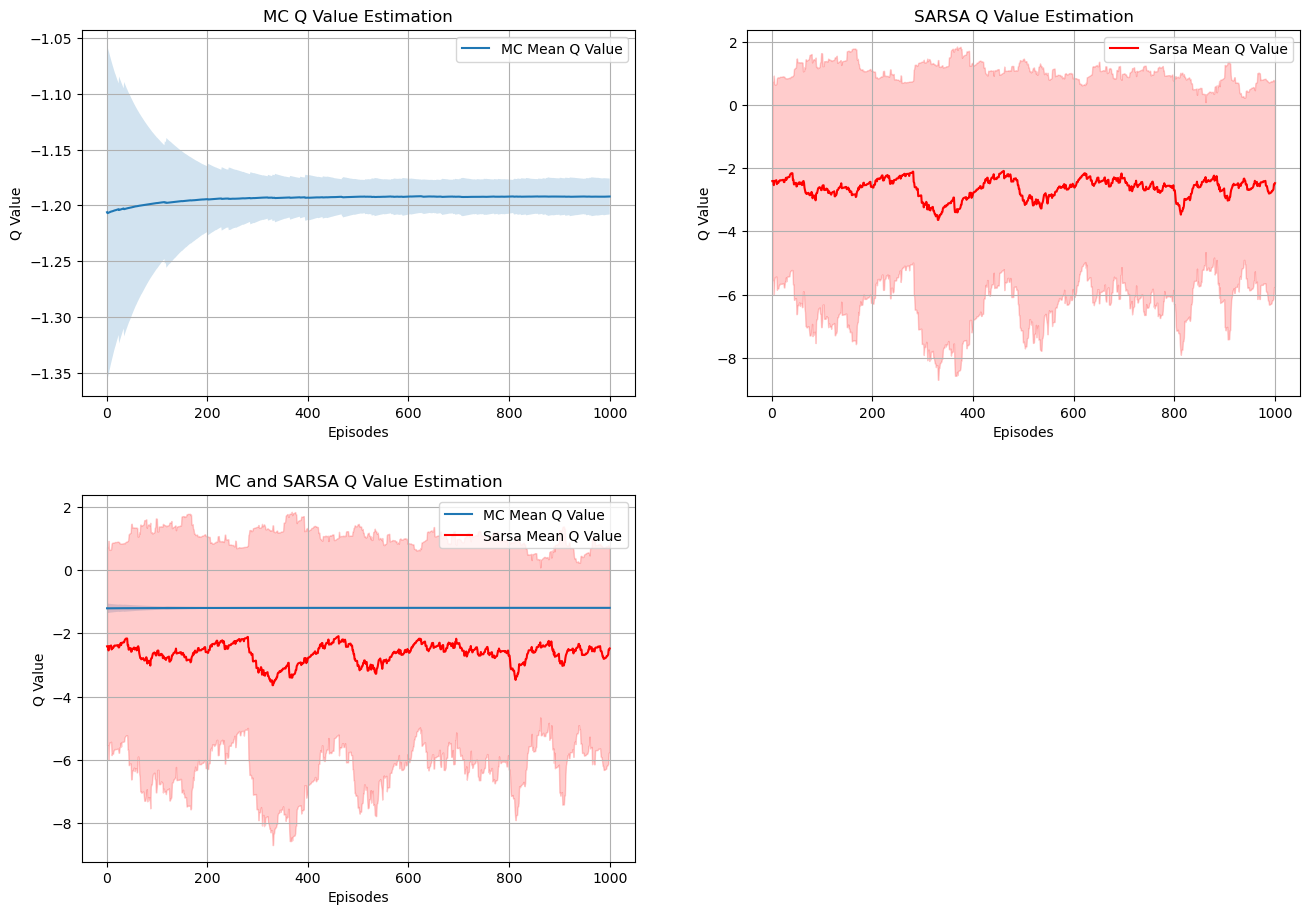

In [34]:
# Convert data to NumPy arrays for easier manipulation
data_np_mc = np.array(lots_of_Q_mc)  
data_np_sarsa = np.array(lots_of_Q_sarsa) 

# Calculate the mean and std along the first axis (i.e., over the 100 repeats)
mean_mc = np.mean(data_np_mc, axis=0)
std_mc = np.std(data_np_mc, axis=0)
mean_sarsa = np.mean(data_np_sarsa, axis=0)
std_sarsa = np.std(data_np_sarsa, axis=0)

# Create an array for the x-axis (episodes)
episodes = np.arange(1, 1001) 

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14,10))
fig.tight_layout(pad=5.0)  # Increase the space between subplots for better visibility

# Plot MC data (top left)
axs[0, 0].plot(episodes, mean_mc, label='MC Mean Q Value')
axs[0, 0].fill_between(episodes, mean_mc - std_mc, mean_mc + std_mc, alpha=0.2)
axs[0, 0].set_title('MC Q Value Estimation')
axs[0, 0].set_xlabel('Episodes')
axs[0, 0].set_ylabel('Q Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Sarsa data (top right)
axs[0, 1].plot(episodes, mean_sarsa, color='r', label='Sarsa Mean Q Value')
axs[0, 1].fill_between(episodes, mean_sarsa - std_sarsa, mean_sarsa + std_sarsa, color='r', alpha=0.2)
axs[0, 1].set_title('SARSA Q Value Estimation')
axs[0, 1].set_xlabel('Episodes')
axs[0, 1].set_ylabel('Q Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot MC and Sarsa data (bottom)
axs[1, 0].plot(episodes, mean_mc, label='MC Mean Q Value')
axs[1, 0].fill_between(episodes, mean_mc - std_mc, mean_mc + std_mc, alpha=0.2)
axs[1, 0].plot(episodes, mean_sarsa, color='r', label='Sarsa Mean Q Value')
axs[1, 0].fill_between(episodes, mean_sarsa - std_sarsa, mean_sarsa + std_sarsa, color='r', alpha=0.2)
axs[1, 0].set_title('MC and SARSA Q Value Estimation')
axs[1, 0].set_xlabel('Episodes')
axs[1, 0].set_ylabel('Q Value')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Remove the unused subplot (if any)
fig.delaxes(axs[1,1])
plt.show()

I expected a different result. The complete opposite to be exact. Since the MC method normally has a high variance from the sampling.  
But we are only looking and updating one state, thus the SARSA one step can’t really learn anything new since the next step will never be updated. I guess that explains the mess in the one step SARSA data. 